# Training a Convnet on a Real World Dataset

---
## Introduction
Before we begin, take a look at this scene from Silicon Valley.

[![Hot Dog vs. Not Hot Dog Video](https://img.youtube.com/vi/vIci3C4JkL0/0.jpg)](https://www.youtube.com/watch?v=vIci3C4JkL0)

In this post, we are going to use convnets to solve a similar task. We will use the [Food-5K Dataset](https://mmspg.epfl.ch/food-image-datasets) to train a convnet to distinguish between food and not food. In the process, we will cover the following: (1) how to work with a real world dataset where images ~~may~~ _will_ be different sizes, and (2) how to use data augmentation to ~~prevent~~ _reduce_ overfitting when training on a small dataset. In the next post, we will cover some more advanced techniques to make our food classifier even better.

---
## Building a First Network

### Preparing our Data
First, we have to collect our data and separate it into training, validation, and test sets. Go ahead and download the Food-5K dataset from [this website](https://mmspg.epfl.ch/food-image-datasets). Place it wherever is most convenient for you – I put it in my Datasets directory – and rename the folders test, train, and validation. 

Currently the files are named `classlabel-samplenumber.jpg`. For example, the 200th non-food image is named `0-200.jpg` and the 150th food image is named `1-150.jpg`. Rather than having the classes separated by a prefix in the filename, we will move them into their own directories. We will also rename the files to `classname-samplenumber.jpg` so the 200th non-food image wil be renamed `nonfood-200.jpg` and the 150th food image will be renamed `food-150.jpg`. 

The code below will take the existing Food-5K data and reformat it as described above. Make sure you rename the `food_5k_dir` variable to the appropriate path for your data.

In [36]:
import os 
import shutil

# R E N A M E  T H I S
food_5k_dir = '/Users/jtbergman/Datasets/Food-5K/'

# Current directory names 
train_dir = os.path.join(food_5k_dir, 'train')
test_dir = os.path.join(food_5k_dir, 'test')
val_dir = os.path.join(food_5k_dir, 'validation')

# Create food/nonfood directories
directories = [train_dir, test_dir, val_dir]
for directory in directories:
    food_dir = os.path.join(directory, 'food')
    nonfood_dir = os.path.join(directory, 'nonfood')
    if not os.path.isdir(food_dir):
        os.mkdir(food_dir)
    if not os.path.isdir(nonfood_dir):
        os.mkdir(nonfood_dir)
    
# Iterate over the current train, test, and validation directory
for directory in directories:
    # Count the number of food/non-food images in each directory
    food = 0
    non_food = 0
    # Filepaths for the food and non-food destination directories
    food_dir = os.path.join(directory, 'food')
    nonfood_dir = os.path.join(directory, 'nonfood')
    # Iterate over each file in the directory 
    for file in os.listdir(directory):
        if not os.path.isdir(file):
            # Get the full file path of the current image 
            source = os.path.join(directory, file)
            # Based on its label, move it to the food or nonfood directory
            if file[0] == '0':
                filename = 'nonfood-' + str(non_food) + '.jpg'
                destination = os.path.join(nonfood_dir, filename)
                shutil.move(source, destination)
                non_food += 1
            elif file[0] == '1':
                filename = 'food-' + str(food) + '.jpg'
                destination = os.path.join(food_dir, filename)
                shutil.move(source, destination)
                food += 1

A quick glance at the output data reveals the following
+ There are 1,500 food training images and 1,500 nonfood training images.
+ There are 500 food validation images and 500 nonfood validation images.
+ There are 500 food testing images and 500 nonfood testing images.

### Building the Network
We are going to use the following network architecture:
1. Conv -> Pool, 32 filters, 3x3 each
2. Conv -> Pool, 64 filters, 3x3 each
3. Conv -> Pool, 128 filters, 3x3 each
4. Conv -> Pool, 128 filters, 5x5 each 
5. Flatten 
6. Dense Layer, 256 nodes, relu activation
7. Output Layer, 1 node, sigmoid activation

In [ ]:
from keras import layers 
from keras import models 

model = models.Sequential()

# 1. Conv -> Pool
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150, 3)))
model.add(layers.MaxPooling2D((2,2)))

# 2. Conv -> Pool
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# 3. Conv -> Pool 
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# 4. Conv -> Pool
model.add(layers.Conv2D(128, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# 5. Flatten
model.add(layers.Flatten())

# 6. Dense Layer
model.add(layers.Dense(256, activation='relu'))

# 7. Output Layer
model.add(layers.Dense(1, activation='sigmoid'))

# Use Binary Crossentropy Loss and RMSprop optimizer
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

One thing to note is that in layer 1 we say we expect the input shape to be `(150, 150, 3)`, so we will have to format our images to have this shape. If you take a look at the dataset, you will see that there are images of many different sizes. Fortunately, Keras will make this easy to handle as shown in the next section.

### Data Preprocessing

#### Image Data Generator
We will simplify our data processing with Keras' `ImageDataGenerator`. From the [Keras docs](https://keras.io/preprocessing/image/#ImageDataGenerator)

> Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).

This class will enable us to easily create minibatches and apply the same pre-processing to each of them. In the code below, we use  `ImageDataGenerator` to scale all of our pixel values between 0 and 1. `ImageDataGenerator` also allows us to perform "real-time data augmentation," but that will be explained after we train our baseline model 😉 

#### Flow from Directory
After creating a data generator, we have to provide it with a datasource. We will do this using the `flow_from_directory` method. From the [docs](https://keras.io/preprocessing/image/#flow_from_directory)

> Takes the path to a directory & generates batches of augmented data.

The most important arguments here are the directory we are using to supply the data and the target size. In our model we said all inputs would have shape `(150, 150, 3)` so we have to specify the target size as `(150, 150)`. There are lots of useful parameters available for this method, so I recommend you take a quick look at the docs. 

#### Organizing your Data
There is one other extremely important step regarding `flow_from_directory`. From the docs 

> directory: Path to the target directory. It should contain one subdirectory per class.

The directory we provide should contain one subdirectory per class – in our case the classes are food and non-food. Originally, our food and non-food images were all mixed together and the only way to distinguish them was by the label prefixed in the filename. That's why we rearranged the data into separate folders during the data preparation step. Feel free to go look at the reformatted dataset and verify that there is one subdirectory per class now 👌

#### Data Preprocessing with Keras

In [32]:
from keras.preprocessing.image import ImageDataGenerator
import os 

# Rescale all images to take pixel values between 0 and 1
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the datasources
base_path = '/Users/jtbergman/Datasets/Food-5K/'
train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'validation')

# Create the data generators 
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir, 
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training
When training a model using data generators, we have to use the [`fit_generator`](https://keras.io/models/sequential/#fit_generator) function. Generators will provide data endlessly in cycles, so we have to be a bit more careful about defining our epochs. In the previous step, we said we would use 20 images per batch. Since we have 3000 training images, we should use 3000 / 20 = 150 steps per epoch. Similarly for the validation data, we have 1000 validation images, so we should use 1000 / 20 = 50 steps per epoch. Finally, we just say that we would like to perform 20 epochs. 

Note: This model will take ~1 hour to train on CPU. Use a GPU if possible.

In [33]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=150,
    epochs=20,
    validation_data=val_generator,
    validation_steps=50)

Epoch 1/20
150/150 [==============================] - 179s 1s/step - loss: 0.6332 - acc: 0.7200 - val_loss: 0.4599 - val_acc: 0.8000
Epoch 2/20
150/150 [==============================] - 177s 1s/step - loss: 0.4596 - acc: 0.8010 - val_loss: 0.4105 - val_acc: 0.8270
Epoch 3/20
150/150 [==============================] - 177s 1s/step - loss: 0.4040 - acc: 0.8243 - val_loss: 0.3228 - val_acc: 0.8660
Epoch 4/20
150/150 [==============================] - 176s 1s/step - loss: 0.3563 - acc: 0.8537 - val_loss: 0.2816 - val_acc: 0.8870
Epoch 5/20
150/150 [==============================] - 198s 1s/step - loss: 0.3245 - acc: 0.8650 - val_loss: 0.3331 - val_acc: 0.8740
Epoch 6/20
150/150 [==============================] - 197s 1s/step - loss: 0.3044 - acc: 0.8793 - val_loss: 0.2724 - val_acc: 0.8860
Epoch 7/20
150/150 [==============================] - 204s 1s/step - loss: 0.2865 - acc: 0.8877 - val_loss: 0.2958 - val_acc: 0.8760
Epoch 8/20
150/150 [==============================] - 223s 1s/step - 

The model actually did pretty well, and it took a while to train, so be sure to save it 🛠

In [34]:
model.save('food_vs_notfood_v1.h5')

### Evaluation
As usual, let's plot the training and validation loss/accuracy curves.

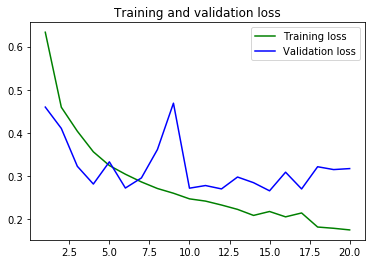

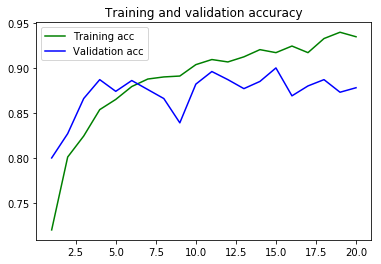

In [35]:
import matplotlib.pyplot as plt

# Get the data 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs 
epochs = range(1, len(acc) + 1)

# Plot loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

# Plot accuracy
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

Overall, our model did pretty well. This is a balanced binary classification problem, so if we were to just guess "food" or "not food" randomly, we would expect to get 50% accuracy. We ended up getting 93.5% accuracy on our training data and 87.8% accuracy on our validation set. While this is a huge improvement from random guessing, there is definitely room for improvement. 

The graphs above show that we are overfitting a bit, especially after epoch 15. Furthermore, looking at an image and saying whether it is food or not-food is something humans can do with nearly 100% accuracy, so 87.8% accuracy is not too impressive (that being said, I am always surprised when code _I wrote_ works at all). 

Our 87.8% accuracy is justifiable. We used a fairly small convnet with only four convolutional layers and 1,683,137 trainable parameters, and we only ran it for 20 epochs. Given more time, there is a good chance we could have performed better. In the next section, we are going to look at one method of addressing overfitting in convnets, and we will train a new network for 20 epochs.  

---
## Improving our Model: Data Augmentation
One cause of overfitting is how few samples we have. Over time, our network gradually learns to recognize our training images better and better, until eventually it starts learning features that are unique just to our training set. Therefore, one way to prevent overfitting is by gather new data and creating an even larger dataset. 

Unfortunately, scraping the web for data is time consuming, especially if you want to manually check every sample to ensure it has been assigned the appropriate class. Instead, we can use one trick to "generate" new data. We can apply small transformations to our existing training set to force our model to learn on slightly different images during each epoch. This should help prevent overfitting, but it is important to keep in mind that these "augmented" images are still highly correlated with the image data, so it's not the perfect solution.

### Data Augmentation in Keras
Creating augmented data is as simple as providing aditional arguments to `ImageDataGenerator`
+ `rotation_range` How many degrees can images be rotated 
+ `width_shift_range` How far can images be translated horizontally
+ `height_shift_range` How far can images be translated horizontally
+ `shear_range` randomly applies shearing transformation
+ `zoom_range` randomly zooms inside pictures
+ `horizontal_flip` randomly flips half the images over their vertical axis
+ `fill_mode` how to fill newly created pixels resulting from augmentation

The code below will define a few transformations.

In [87]:
generator = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=.05,
    height_shift_range=.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

Let's feed some of our training images to this generator and view them.

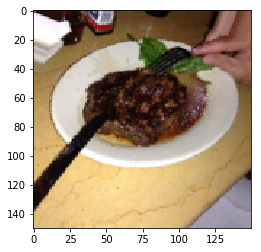

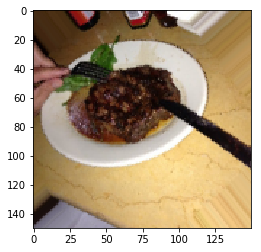

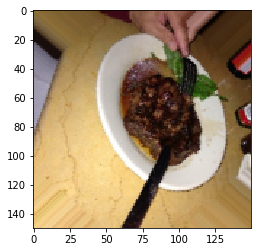

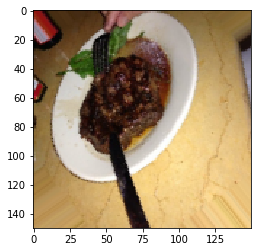

In [89]:
from keras.preprocessing import image 

# Training 'food' directory 
food_dir = os.path.join(train_dir, 'food')

# Get all filenames 
files = [os.path.join(food_dir, fname) for fname in os.listdir(food_dir)]

# Select an image to augment - FEEL FREE TO CHANGE THIS
img_path = files[5]

# Load it with appropriate size 
img = image.load_img(img_path, target_size=(150, 150))
img = image.img_to_array(img)
img = img.reshape((1,) + img.shape)

# Create four transformations
i = 0 
for batch in generator.flow(img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0: break 
        
plt.show()

As you can see, we get four different versions of the same image. To us these may seem similar, but to a computer, they can seem quite different. There are some pretty weird artifacts appearing in these images, especially around the border, so we'll take it a little easier with our model.

### Using Data Augmentation with our Model
We will redefine our training data generator to automatically apply augment our training data using a number of transforms. Note: We don't use agumentation with our validation set. 

In [75]:
# Training Image Data Generator with Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# Validation Image Data Generator
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the datasources
base_path = '/Users/jtbergman/Datasets/Food-5K/'
train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'validation')

# Create the data generators 
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir, 
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Now, we'll create a new network and train our model for 20 epochs. Originally, I intended to just perform 20 additional epochs on the previous model, but I found it was really struggling to learn the augmented data. I decided to change the final conv layer to use 256, 3x3 filters instead of 128, 5x5 filters, and I changed the dense layer to use 512 nodes instead of 256. 

In hindsight, I don't think the first model was that bad. Since we saved it, you can always reload it and try running the following experiments using it instead of this newer model. 

### Creating a New Model
As just described, we will be using the following network architecture
1. Conv -> Pool, 32 filters, 3x3 each
2. Conv -> Pool, 64 filters, 3x3 each
3. Conv -> Pool, 128 filters, 3x3 each
4. Conv -> Pool, 256 filters, 3x3 each (UPDATED)
5. Flatten 
6. Dense Layer, 512 nodes, relu activation (UPDATED)
7. Output Layer, 1 node, sigmoid activation

In [78]:
from keras import layers 
from keras import models 

model = models.Sequential()

# 1. Conv -> Pool
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150, 3)))
model.add(layers.MaxPooling2D((2,2)))

# 2. Conv -> Pool
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# 3. Conv -> Pool 
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# 4. Conv -> Pool
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# 6. Flatten
model.add(layers.Flatten())

# 7. Dense Layer
model.add(layers.Dense(512, activation='relu'))

# 9. Output Layer
model.add(layers.Dense(1, activation='sigmoid'))

# Use Binary Crossentropy Loss and RMSprop optimizer
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 15, 15, 256)       295168    
__________

### Training our Model with Data Augmentation
This is pretty similar to before, expect it to take quite a while to train 🙃

In [79]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=150,
    epochs=20,
    validation_data=val_generator,
    validation_steps=50)

Epoch 1/20
150/150 [==============================] - 259s 2s/step - loss: 0.6427 - acc: 0.7320 - val_loss: 0.5331 - val_acc: 0.8040
Epoch 2/20
150/150 [==============================] - 254s 2s/step - loss: 0.4996 - acc: 0.7820 - val_loss: 0.3782 - val_acc: 0.8470
Epoch 3/20
150/150 [==============================] - 246s 2s/step - loss: 0.4390 - acc: 0.8243 - val_loss: 0.3807 - val_acc: 0.8370
Epoch 4/20
150/150 [==============================] - 238s 2s/step - loss: 0.4030 - acc: 0.8317 - val_loss: 0.3179 - val_acc: 0.8590
Epoch 5/20
150/150 [==============================] - 242s 2s/step - loss: 0.4184 - acc: 0.8330 - val_loss: 1.8714 - val_acc: 0.6450
Epoch 6/20
150/150 [==============================] - 254s 2s/step - loss: 0.3852 - acc: 0.8427 - val_loss: 0.2991 - val_acc: 0.8780
Epoch 7/20
150/150 [==============================] - 244s 2s/step - loss: 0.3646 - acc: 0.8550 - val_loss: 0.8641 - val_acc: 0.7920
Epoch 8/20
150/150 [==============================] - 206s 1s/step - 

### Evaluating our Model

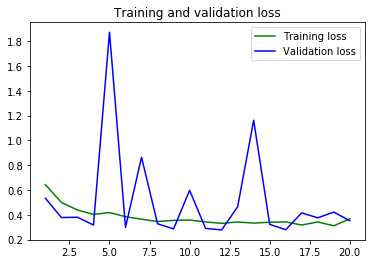

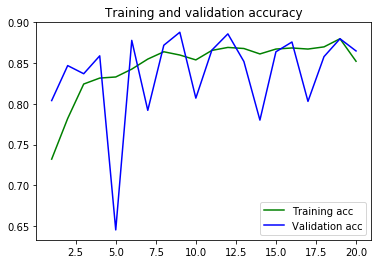

In [80]:
import matplotlib.pyplot as plt

# Get the data 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs 
epochs = range(1, len(acc) + 1)

# Plot loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

# Plot accuracy
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In the end, we get 85% training accuracy and 86.5% validation accuracy. With the previous model we got 87.8% validation accuracy, so this model is actually performing a bit worse, but we were able to solve the overfitting problem. In the next post, we'll look at some techniques for boosting our accuracy, so we don't need to worry too much about that yet. 

### Test Set Performance
Let's see how we did on our truly unseen data.

In [82]:
# Test Directory 
test_dir = os.path.join(base_path, 'test')

# Test Image Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Evaluate all 1,000 test images
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

# Evaluate: This step is also a little slow
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Test Accuracy', test_acc)

Found 1000 images belonging to 2 classes.
Test Accuracy 0.842999997138977


84.3% accuracy isn't bad either – yeah, compared to a human it is – but as promised we'll work on this in the next post.

### Saving the Model
We're going to revisit this model in the next post, so let's save it for future use 👌

In [83]:
model.save('food_vs_notfood_v2.h5')

---
## Summary
In this post you learned to preprocess data and augment data to reduce overfitting. Let's review.

### Use Keras to Preprocess Data 
We saw how to use Keras to generate batches and apply conistent preprocessing to each.

```python
# 1. Create an instance of ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)

# 2. Define the path to the datasource 
base_path = '/Users/jtbergman/Datasets/Food-5K/'
directory = 'train'
train_dir = os.path.join(base_path, directory)

# 3. Use flow_from_directory to define datasource, target size, batch size, etc.
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
```

### User Keras to Augment Data
You also saw how to use Keras to augment training data and reduce overfitting.

#### For Training
```python
# 1. Create an instance of ImageDataGenerator with your transformations specified
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# 2. DON'T use data augmentation on validation images 
val_datagen = ImageDataGenerator(rescale=1./255)

# 3. Use flow_from_directory to set up your generator as in the previous example
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# 4. Use fit_generator to train. Remember to carefully choose steps per epoch.
history = model.fit_generator(
    train_generator,
    steps_per_epoch=150,
    epochs=20,
    validation_data=val_generator,
    validation_steps=50)
```

#### For Testing
```python 
# 1. Create an instance of ImageDataGenerator like the one used on your validation data
test_datagen = ImageDataGenerator(rescale=1./255)

# 2. Use flow_from_directory to create the generator 
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
        
# 3. Remember to use evaluate_generator when testing 
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
```

### Documentation Worth Reading
The Keras documentation is incredibly easy to read. Consider checking these out.
+ [`ImageDataGenerator`](https://keras.io/preprocessing/image/#ImageDataGenerator)
+ [`flow_from_directory`](https://keras.io/preprocessing/image/#flow_from_directory)
+ [`fit_generator`](https://keras.io/models/sequential/#fit_generator)

### Datasets in this Post
This post used the [Food-5K dataset](https://mmspg.epfl.ch/food-image-datasets) which provides the following
+ 1,500 'food' training samples and 1,500 'non-food' training samples
+ 500 'food' validation samples and 500 'non-food' validation samples
+ 500 'food' test samples and 500 'non-food' test samples
